# chromatic_fitting

Add-on to the [chromatic](https://github.com/zkbt/chromatic) package to perform a simultaneous multi-wavelength transit fit

In [1]:
from src.inject_spectrum import *
from src.plot.interactive_plots import *
from src.weighted_average_lc import *
from src.recover_transit import *
from src.utils import *
from chromatic_fitting import *

Running on Python v3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:23:20) 
[Clang 12.0.1 ]
Running on numpy v1.22.3
Running on chromatic v0.1.0
Running on PyMC v3.11.2
Running on ArviZ v0.12.0
Running on Exoplanet v0.5.2


## Import Spectrum Model and Inject into Rainbow

In [2]:
x = pickle.load(open('data_challenge_spectra_v01.pickle', 'rb'))
planet = x['WASP39b_NIRSpec']
planet_params = x['WASP39b_parameters']
planet_params

{'cosi': 0.03786459100977565,
 'a_rs': 11.37,
 'period': 4.055259,
 'rstar': 62265150000.0,
 'LDC_niriss1': [0.0, 0.7373, 0.0, -0.2928],
 'LDC_niriss2': [0.0, 0.8253, 0.0, -0.2624],
 'LDC_nirspec': [0.0, 0.2379, 0.0, 0.4615],
 'LDC_nircam': [0.0, 0.2379, 0.0, 0.4615]}

In [ ]:
## load Patricio's spectrum model:
model_staticld, planet_params, wavelength,transmission = import_patricio_model()

# add wavelength-dep limb-darkening coeffs:
model_ld = add_ld_coeffs(model_staticld, planet_params, wavelength,transmission,mode="NIRCam_F322W2",star_params = {"M_H": -0.03, "Teff": 5326.6, "logg": 4.38933},plot=True)

# return synthetic rainbow + rainbow with injected transit:
bintime=5
binwave=0.2

# calculate the semi-major axis in stellar radii from the value in AU
# a_AU = 0.0486 # Faedi et al. 2011
# solar_radius_AU = 0.00465047
# stellar_radius = 0.895
# a_stellar_radii = a_AU/(solar_radius_AU * stellar_radius)

injplanet_params = {
            "t0": 0,
            "per": 4.055259, # days, Faedi et al. 2011
            "a": 11.37, # stellar radii
            "inc": 87.83, # degrees, Faedi et al. 2011
            "ecc": 0,
            "w": 0,
#             "limb_dark": "nonlinear",
#             "u": [0.0,0.2379,0.0,0.4615],
        }
# injplanet_params = {}#{'per':2}
r,i = inject_spectrum(model_ld, snr=1000, dt=bintime, res=50, planet_params=injplanet_params)

# bin in time and wavelength (to speed up fitting)
b_withouttransit = r.bin(
        dw=binwave * u.micron, dt=bintime * u.minute
)
b_withtransit = i.bin(
        dw=binwave * u.micron, dt=bintime * u.minute
)

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Liberation Sans
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Liberation Sans
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Liberation Sans
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Liberation Sans


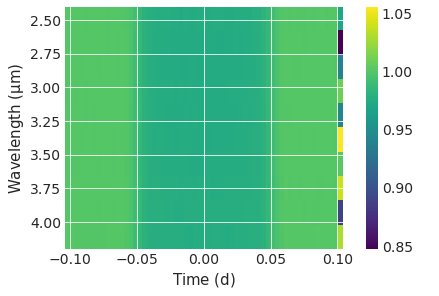

In [4]:
b_withtransit.imshow();

In [5]:
b_withtransit.imshow_interact(custom_ylims=[0.96,1.02])

alt.HConcatChart(...)

In [6]:
b_withtransit.imshow_interact(quantity='uncertainty')

alt.HConcatChart(...)

## Setup Chromatic_Fitting model
Define the priors!

In [43]:
# set initial parameter estimates:
init_t0=0.0
init_period = 4.055259
period_error = 0.000009
init_b=0.44
init_r=0.15
init_mean = 0.0
init_u = [0.05,0.35]
r_s = 0.895
m_s = 0.93

# create chromatic model:
cm = chromatic_model()

# init priors (use same distribution format as pyMC3):
m_s_prior = cm.Normal('m_s', mu=r_s, sigma=0.05, observed=r_s)    # Mass of star (Solar mass, fixed)
r_s_prior = cm.Normal('r_s', mu=m_s, sigma=0.05, observed=m_s)    # Radius of star (Solar radius, fixed)
r_prior = cm.Uniform("r", lower=0.01, upper=0.3, testval=init_r)  # Radius ratio
mean_prior =  cm.Normal("mean", mu=init_mean, sigma=0.0025)       # Lightcurve mean
t0_prior = cm.Normal("t0", mu=init_t0, sigma=0.05)                # Transit epoch (days)
# logP_prior = cm.Normal("logP", mu=np.log(init_period), sigma= np.log(period_error)) - why does this not fit?
logP_prior = cm.Uniform("logP", testval=np.log(init_period), lower=np.log(init_period-(10*period_error)),upper=np.log(init_period+(10*period_error))) # Log(Period, days)

### Initialise the Model (wavelength-indep parts)

In [44]:
# Initialise the (wavelength-independent) model:
cm.initialise_model(r_s_prior, m_s_prior, r_prior, logP_prior, t0_prior, mean_prior, init_b=init_b, init_u=init_u)

Initialising (static) model took --- 0.29648590087890625 seconds ---


Let's look at the model so far:

In [45]:
print(cm.model)

logP_interval__ ~ TransformedDistribution
             t0 ~ Normal
     b_impact__ ~ TransformedDistribution
           logP ~ Uniform
         period ~ Deterministic
              b ~ ImpactParameter
            r_s ~ Normal
            m_s ~ Normal


### Quick Check

How do the priors look compared to the wavelength-averaged data?

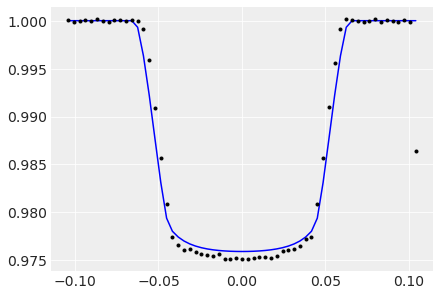

In [46]:
quicklook_priors(b_withtransit,cm)

### Optimise the Model

Run the model, choosing the optimisation we want:
- _weighted_average_
- _separate_wavelengths_
- _simultaneous_

If you want to rerun the model with a different optimisation you need to **.reinitialise()**! 

You can also **.reinitialise()** and apply the model to a different Rainbow object

MAD (entire LC) = 9329.025299681603 ppm
MAD (5-min binned) = 10462.781896074192 ppm
Weighted Average LC took --- 0.03282523155212402 seconds ---


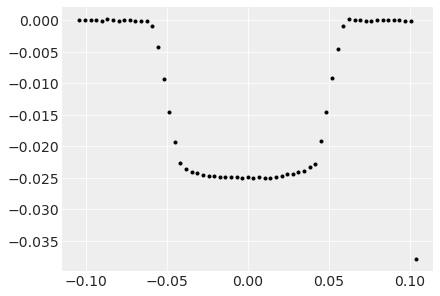

Initialising r/u/mean took --- 0.17049217224121094 seconds ---



🌈 Warning: invalid value encountered in logoptimizing logp for variables: [u, mean, r, b, t0, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -18.869719599182723 -> 429.86810888827904


Optimising model took --- 2.956989288330078 seconds ---
list indices must be integers or slices, not str


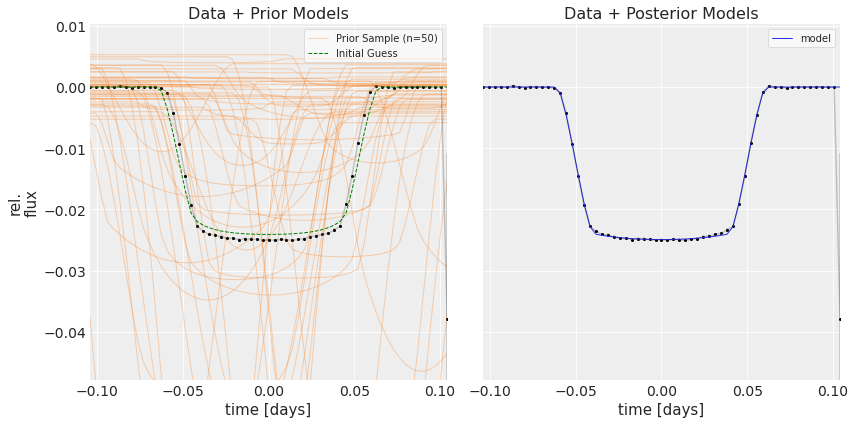

Plotting took --- 0.710068941116333 seconds ---


In [47]:
# cm.reinitialise()
cm.run(r=b_withtransit, optimisation="weighted_average", plot=True)

Let's look at the model again:

In [12]:
print(cm.model)

 logP_interval__ ~ TransformedDistribution
              t0 ~ Normal
      b_impact__ ~ TransformedDistribution
    r_interval__ ~ TransformedDistribution
            mean ~ Normal
u_quadlimbdark__ ~ TransformedDistribution
            logP ~ Uniform
          period ~ Deterministic
               b ~ ImpactParameter
               r ~ Uniform
               u ~ QuadLimbDark
             r_p ~ Deterministic
    light_curves ~ Deterministic
             r_s ~ Normal
             m_s ~ Normal
             obs ~ Normal


You can change a prior and run again:

In [ ]:
cm.change_prior(cm.Uniform("logP", testval=np.log(init_period), lower=np.log(init_period-(10*period_error)), upper=np.log(init_period+(10*period_error))))
cm.run(r=b_withtransit, optimisation="weighted_average", plot=True)

Or the rainbow:

In [ ]:
# create a new Rainbow with lower SNR:
r2,i2 = inject_spectrum(model_ld, snr=100, dt=bintime, res=50, planet_params=injplanet_params)
b_withouttransit2 = r2.bin(
        dw=binwave * u.micron, dt=bintime * u.minute
)
# Reinitialise and rerun model on new Rainbow
cm.reinitialise()
cm.run(r=b_withtransit2, optimisation="weighted_average", plot=True)

### Sample the posterior

Multiprocess sampling (4 chains in 12 jobs)
NUTS: [u, mean, r, b, t0, logP]


Sampling 4 chains for 4_000 tune and 8_000 draw iterations (16_000 + 32_000 draws total) took 32 seconds.
The acceptance probability does not match the target. It is 0.8116742153543617, but should be close to 0.65. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7908763110413294, but should be close to 0.65. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7871763192095672, but should be close to 0.65. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7975135403580077, but should be close to 0.65. Try to increase the number of tuning steps.


Sampling the posterior took --- 56.39300203323364 seconds ---


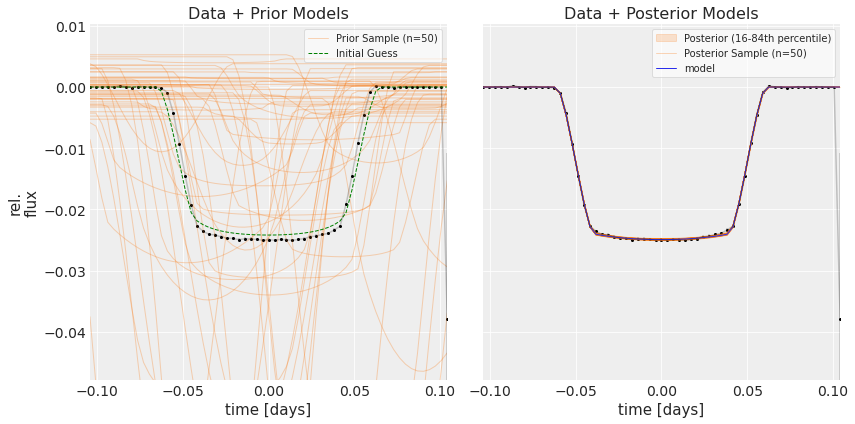

In [13]:
cm.sample_posterior(tune_steps=4000,draws=8000,target_accept=0.65)

Check the MCMC chains:

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Liberation Sans


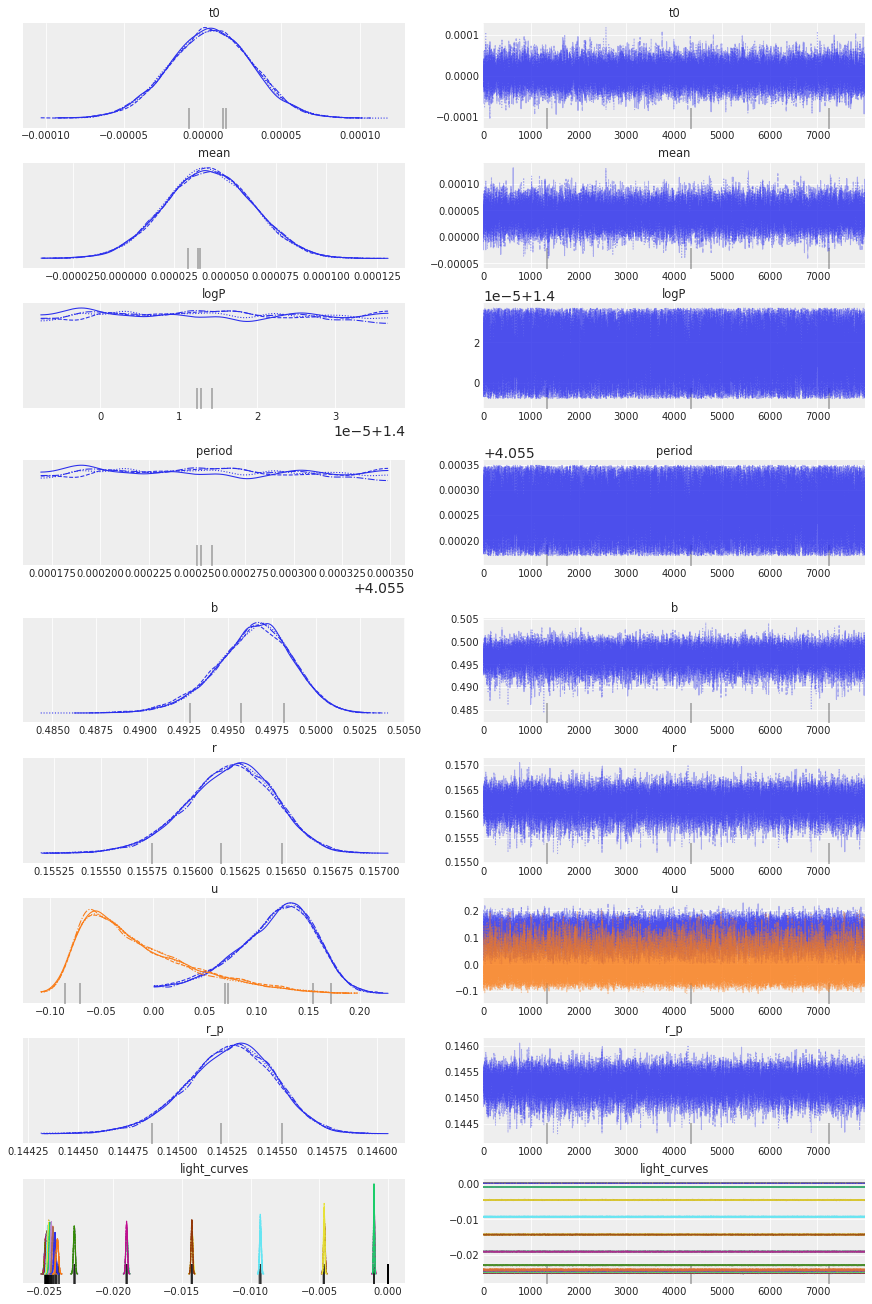

In [14]:
cm.plot_trace();

You can change the properties of the sampling:

In [ ]:
cm.sample_posterior(tune_steps=4000,draws=8000,target_accept=0.8)

Plot the posterior distributions in a corner plot and a summary table: 

Got error No model on context stack. trying to find log_likelihood in translation.


[period ~ Deterministic r ~ Uniform t0 ~ Normal b ~ ImpactParameter
 u ~ QuadLimbDark mean ~ Normal]


mean        sd    hdi_3%   hdi_97%     mcse_mean       mcse_sd  \
period  4.055258  0.000052  4.055178  4.055347  3.000000e-07  2.000000e-07   
r       0.156195  0.000239  0.155758  0.156648  1.600000e-06  1.100000e-06   
t0      0.000005  0.000026 -0.000044  0.000056  1.000000e-07  1.000000e-07   
b       0.496444  0.002196  0.492207  0.500444  1.460000e-05  1.030000e-05   
u[0]    0.116384  0.039596  0.037231  0.184795  2.822000e-04  1.996000e-04   
u[1]   -0.015166  0.053571 -0.090728  0.091559  4.057000e-04  3.227000e-04   
mean    0.000042  0.000022  0.000002  0.000083  1.000000e-07  1.000000e-07   

            ess_bulk      ess_tail     r_hat  
period  31391.437235  20312.239214  1.000248  
r       24731.839220  17630.161776  1.000275  
t0      31063.506351  24112.999950  1.000027  
b       24362.080972  15827.219983  1.000128  
u[0]    19040.024321  17365.536684  1.000087  
u[1]    16121.437990  15183.695427  1.000172  
mean    31565.673776  24584.814748  1.000156

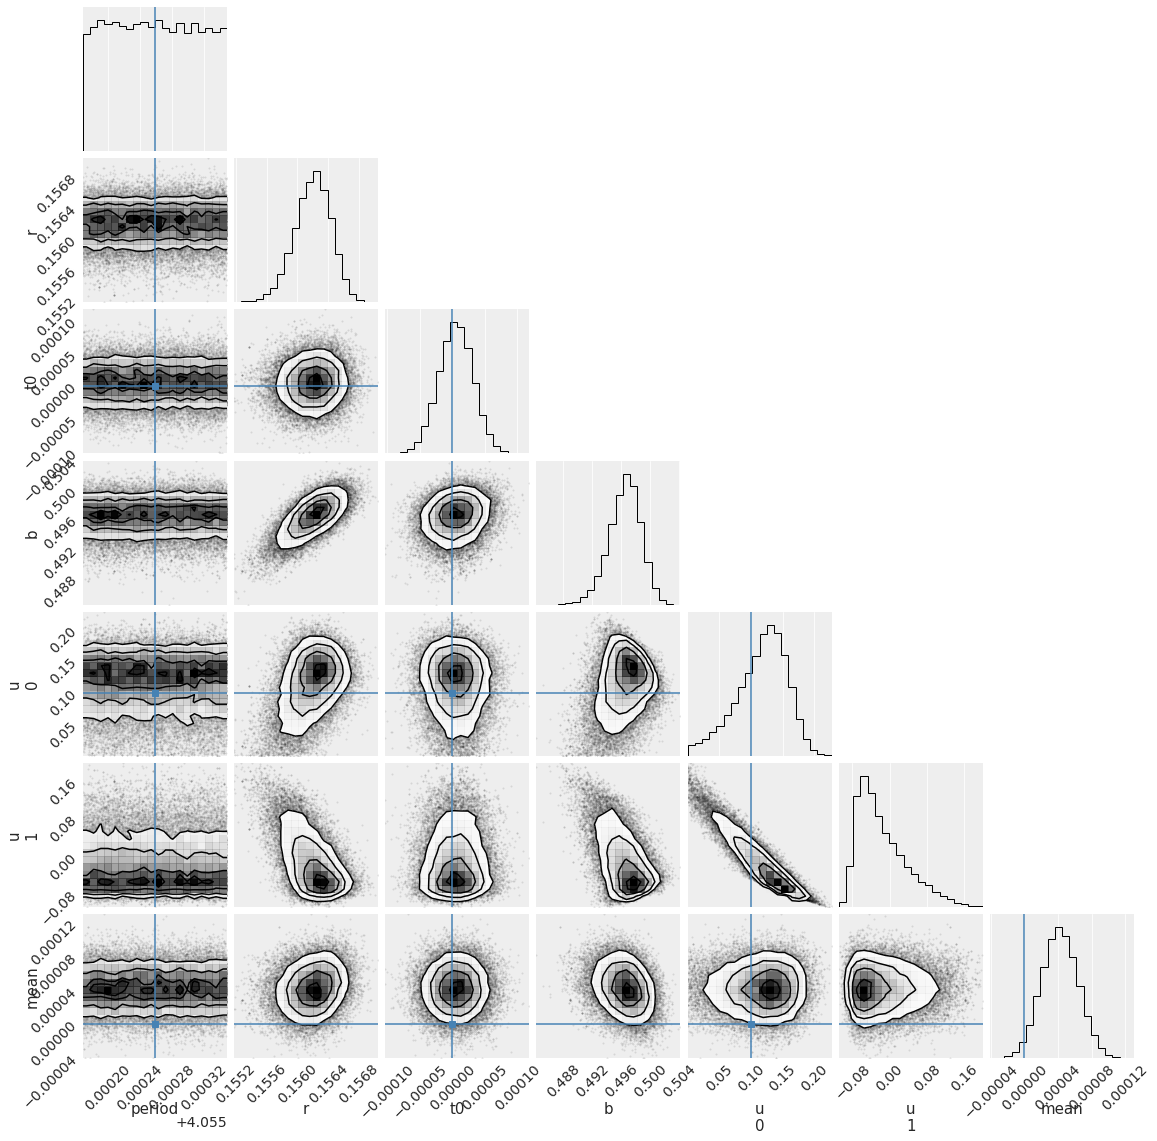

In [15]:
cm.cornerplot()
summary = cm.summarise()
summary

### Optimise using a Different Method

In [ ]:
cm.reinitialise()
cm.run(b_withtransit,optimisation='separate_wavelengths')

Initialising (static) model took --- 0.28671693801879883 seconds ---



🌈 Warning: invalid value encountered in logoptimizing logp for variables: [wavelength_3_mean, wavelength_3_ror, wavelength_3_u, wavelength_2_mean, wavelength_2_ror, wavelength_2_u, wavelength_1_mean, wavelength_1_ror, wavelength_1_u, b, t0, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: 619.1902297232336 -> 1176.492104785474
optimizing logp for variables: [wavelength_3_mean, wavelength_3_u, wavelength_3_ror]


message: Desired error not necessarily achieved due to precision loss.
logp: 1176.492104785474 -> 1176.492104785474


list indices must be integers or slices, not str
list indices must be integers or slices, not str
list indices must be integers or slices, not str


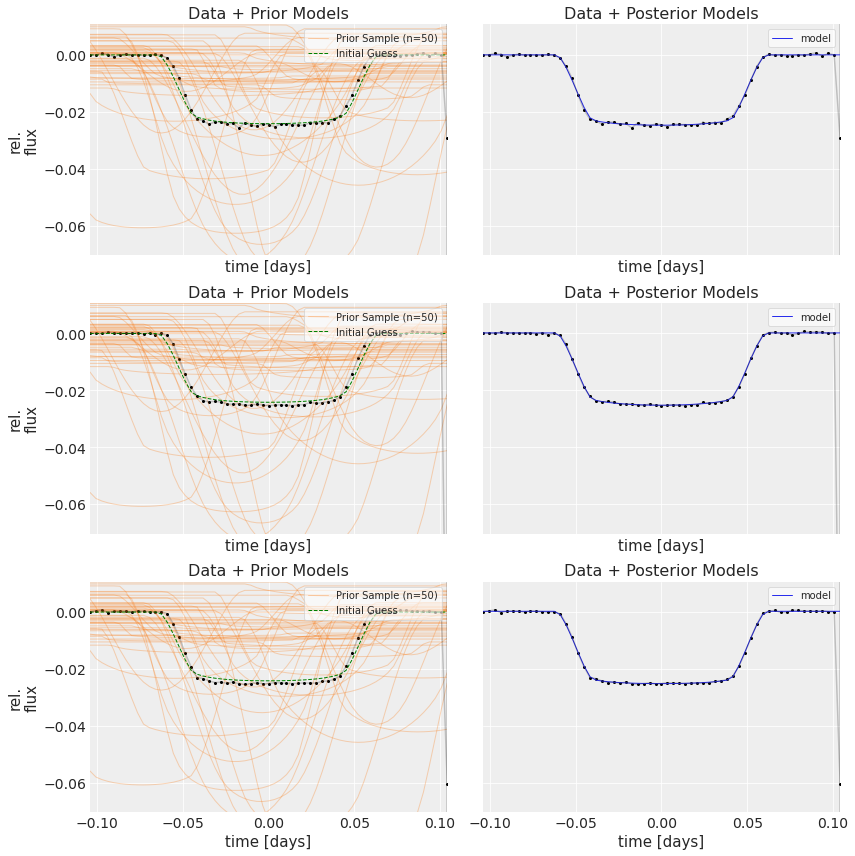

Optimising model took --- 15.189013004302979 seconds ---


In [17]:
cm.reinitialise()
nwave = 3
cm.run(b_withtransit,optimisation='simultaneous',nwave=nwave)

Multiprocess sampling (4 chains in 12 jobs)
NUTS: [wavelength_3_mean, wavelength_3_ror, wavelength_3_u, wavelength_2_mean, wavelength_2_ror, wavelength_2_u, wavelength_1_mean, wavelength_1_ror, wavelength_1_u, b, t0, logP]


Sampling 4 chains for 4_000 tune and 8_000 draw iterations (16_000 + 32_000 draws total) took 115 seconds.


Sampling the posterior took --- 195.06149101257324 seconds ---


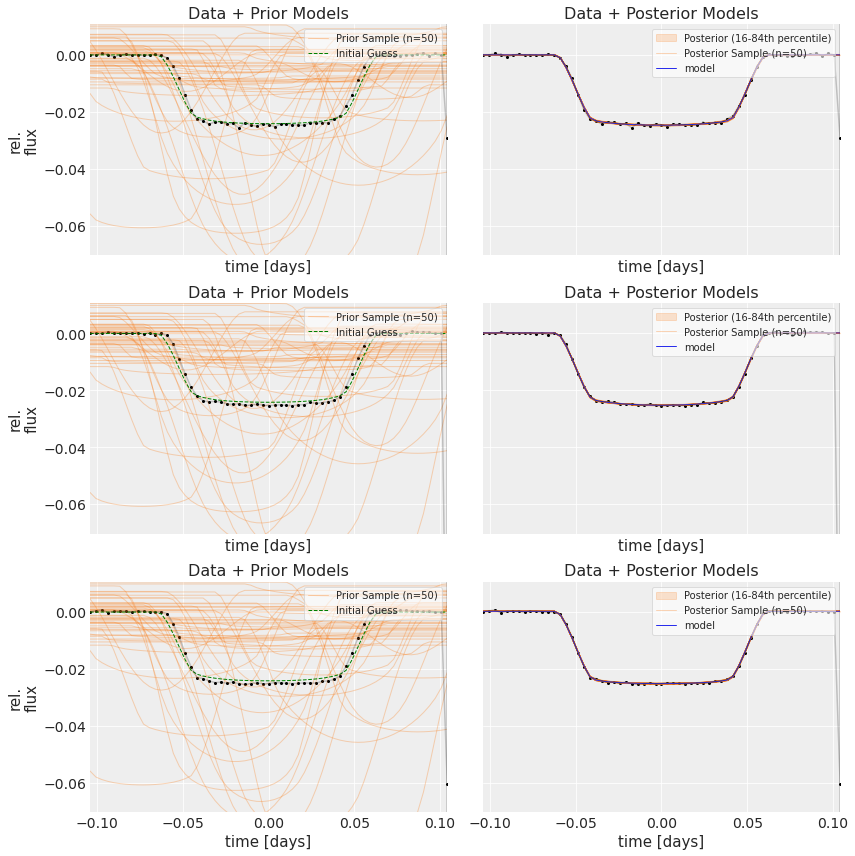

In [18]:
cm.sample_posterior()

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


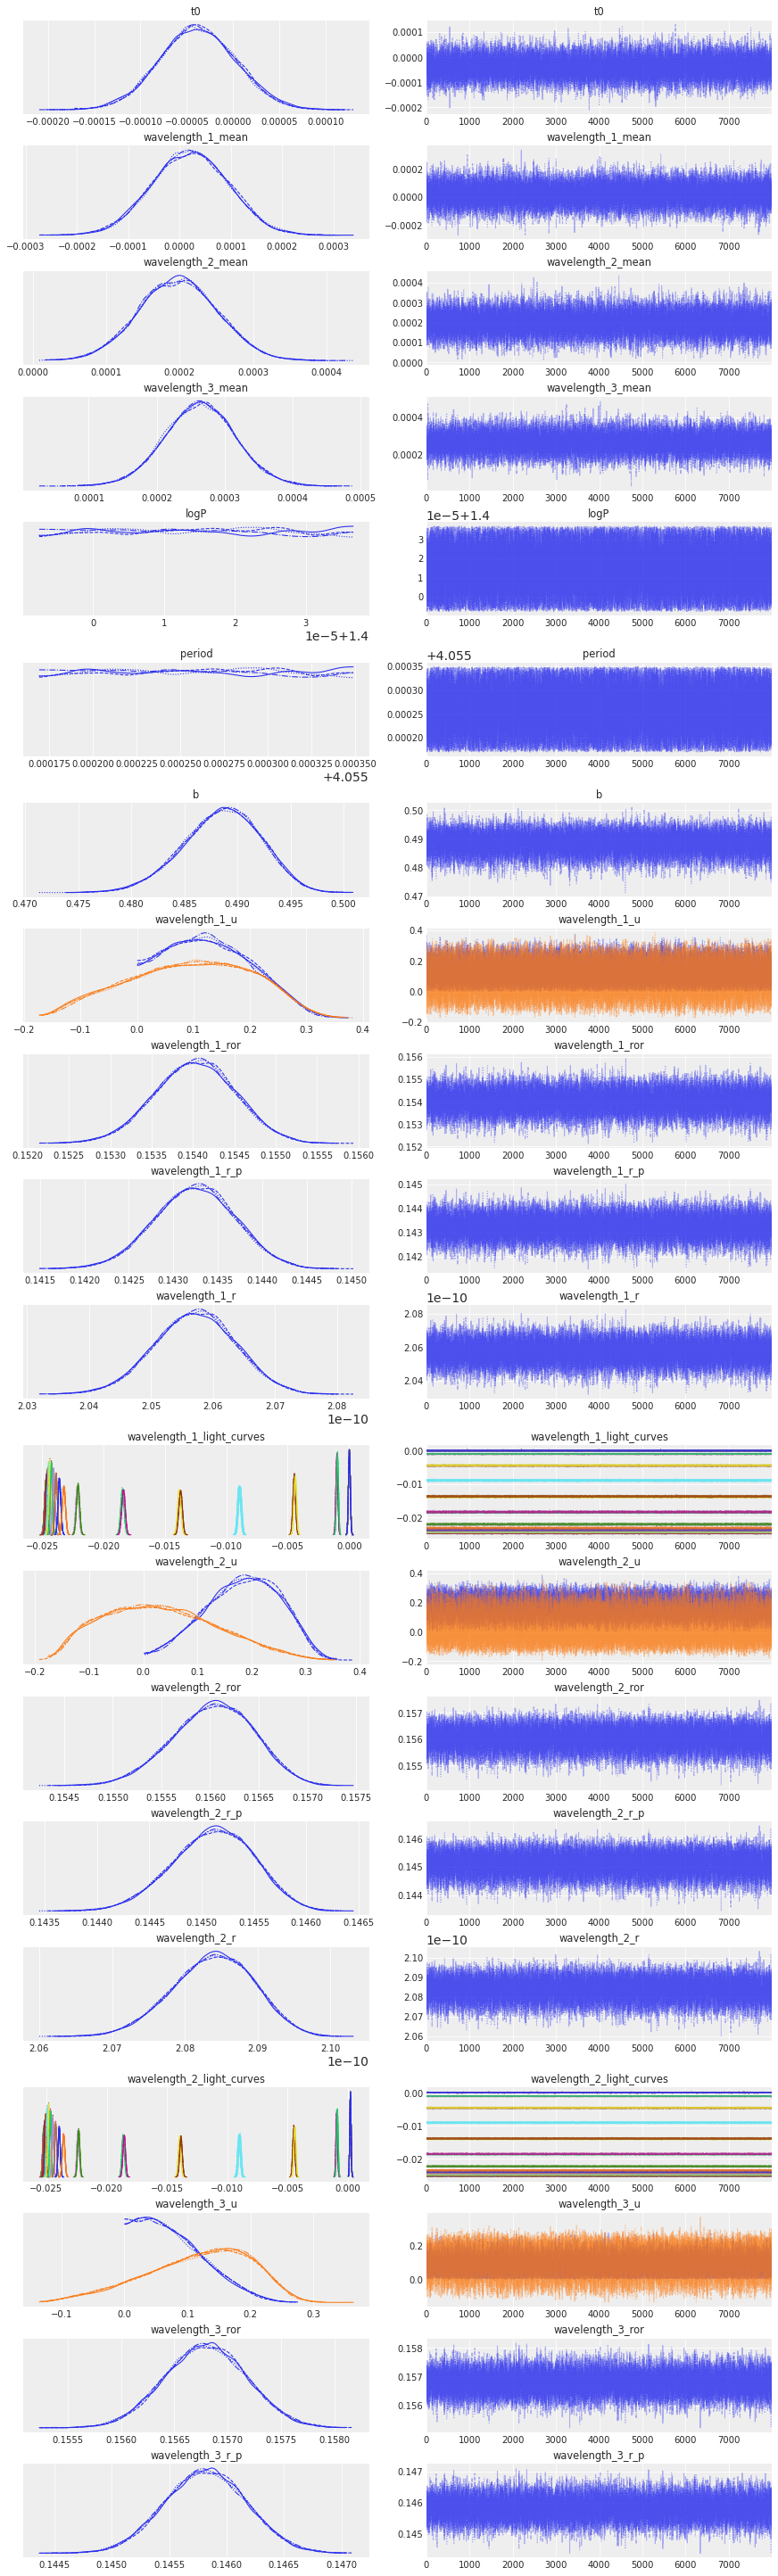

In [19]:
cm.plot_trace()

object of type 'builtin_function_or_method' has no len()
object of type 'builtin_function_or_method' has no len()
object of type 'builtin_function_or_method' has no len()


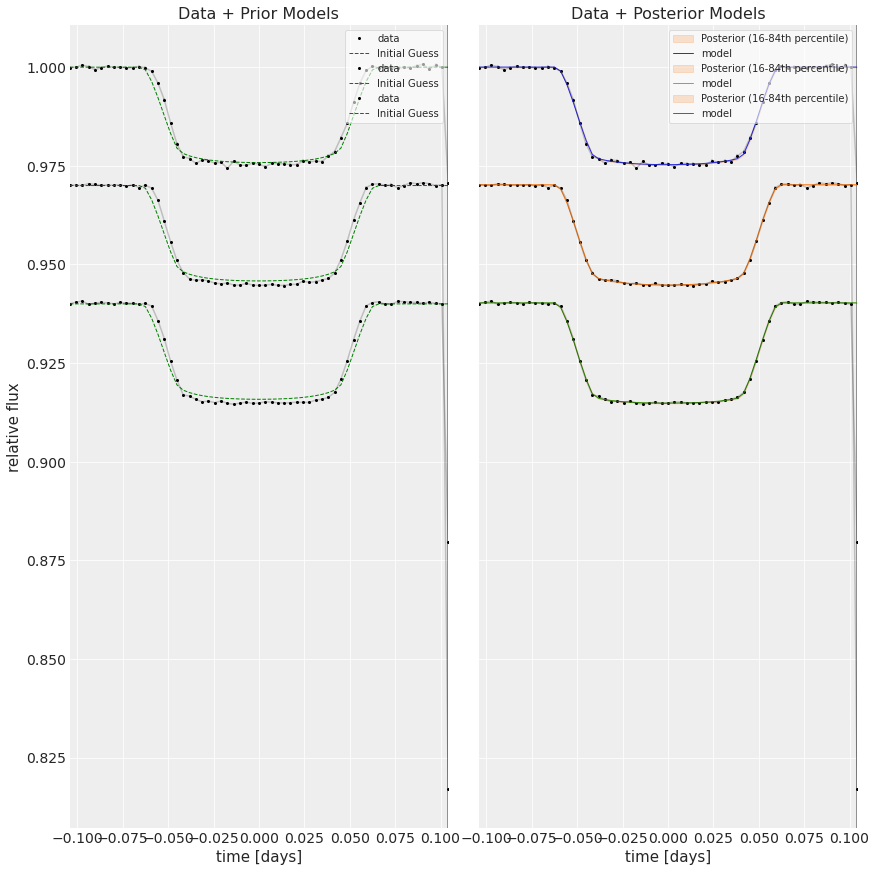

In [20]:
cm.plot_simultaneous_fit() # a better plot for seeing all fits at once?

### Compare to model!

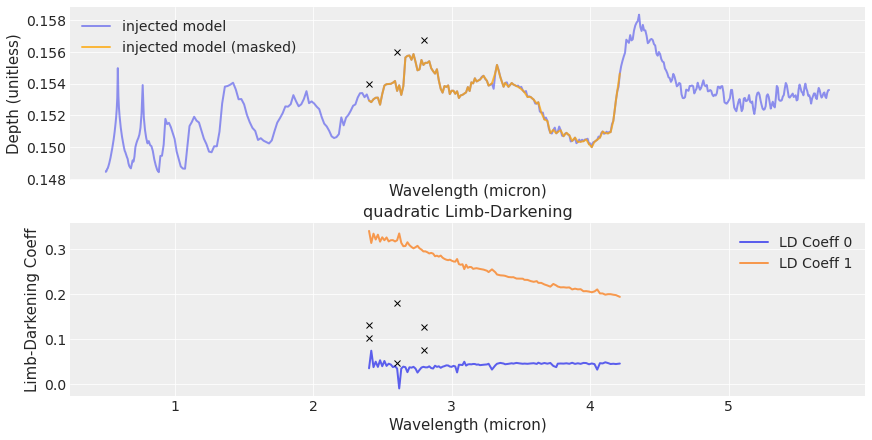

In [42]:
# nwave = 3
fig,(ax1,ax2) = plt.subplots(nrows=2,sharex=True,figsize=(12, 6))
ax1 = model_ld.plot(ax=ax1)
ax1 = model_ld.plotmask(ax=ax1)
ax2 = model_ld.plotLDcoeffs(ax=ax2)
for n in range(nwave):
    u_ld = cm.result[f'wavelength_{n+1}_u']
    ax2.plot(cm.wavelength[n],u_ld[0],'kx')
    ax2.plot(cm.wavelength[n],u_ld[1],'kx')
    ror = cm.result[f'wavelength_{n+1}_ror']
    ax1.plot(cm.wavelength[n],ror,'kx')
ax1.legend(frameon=False)
ax2.legend(frameon=False)
plt.show()
plt.close()

## Trying out Corner + Summary with the multi-wavelength fit (v experimental!)

Got error No model on context stack. trying to find log_likelihood in translation.


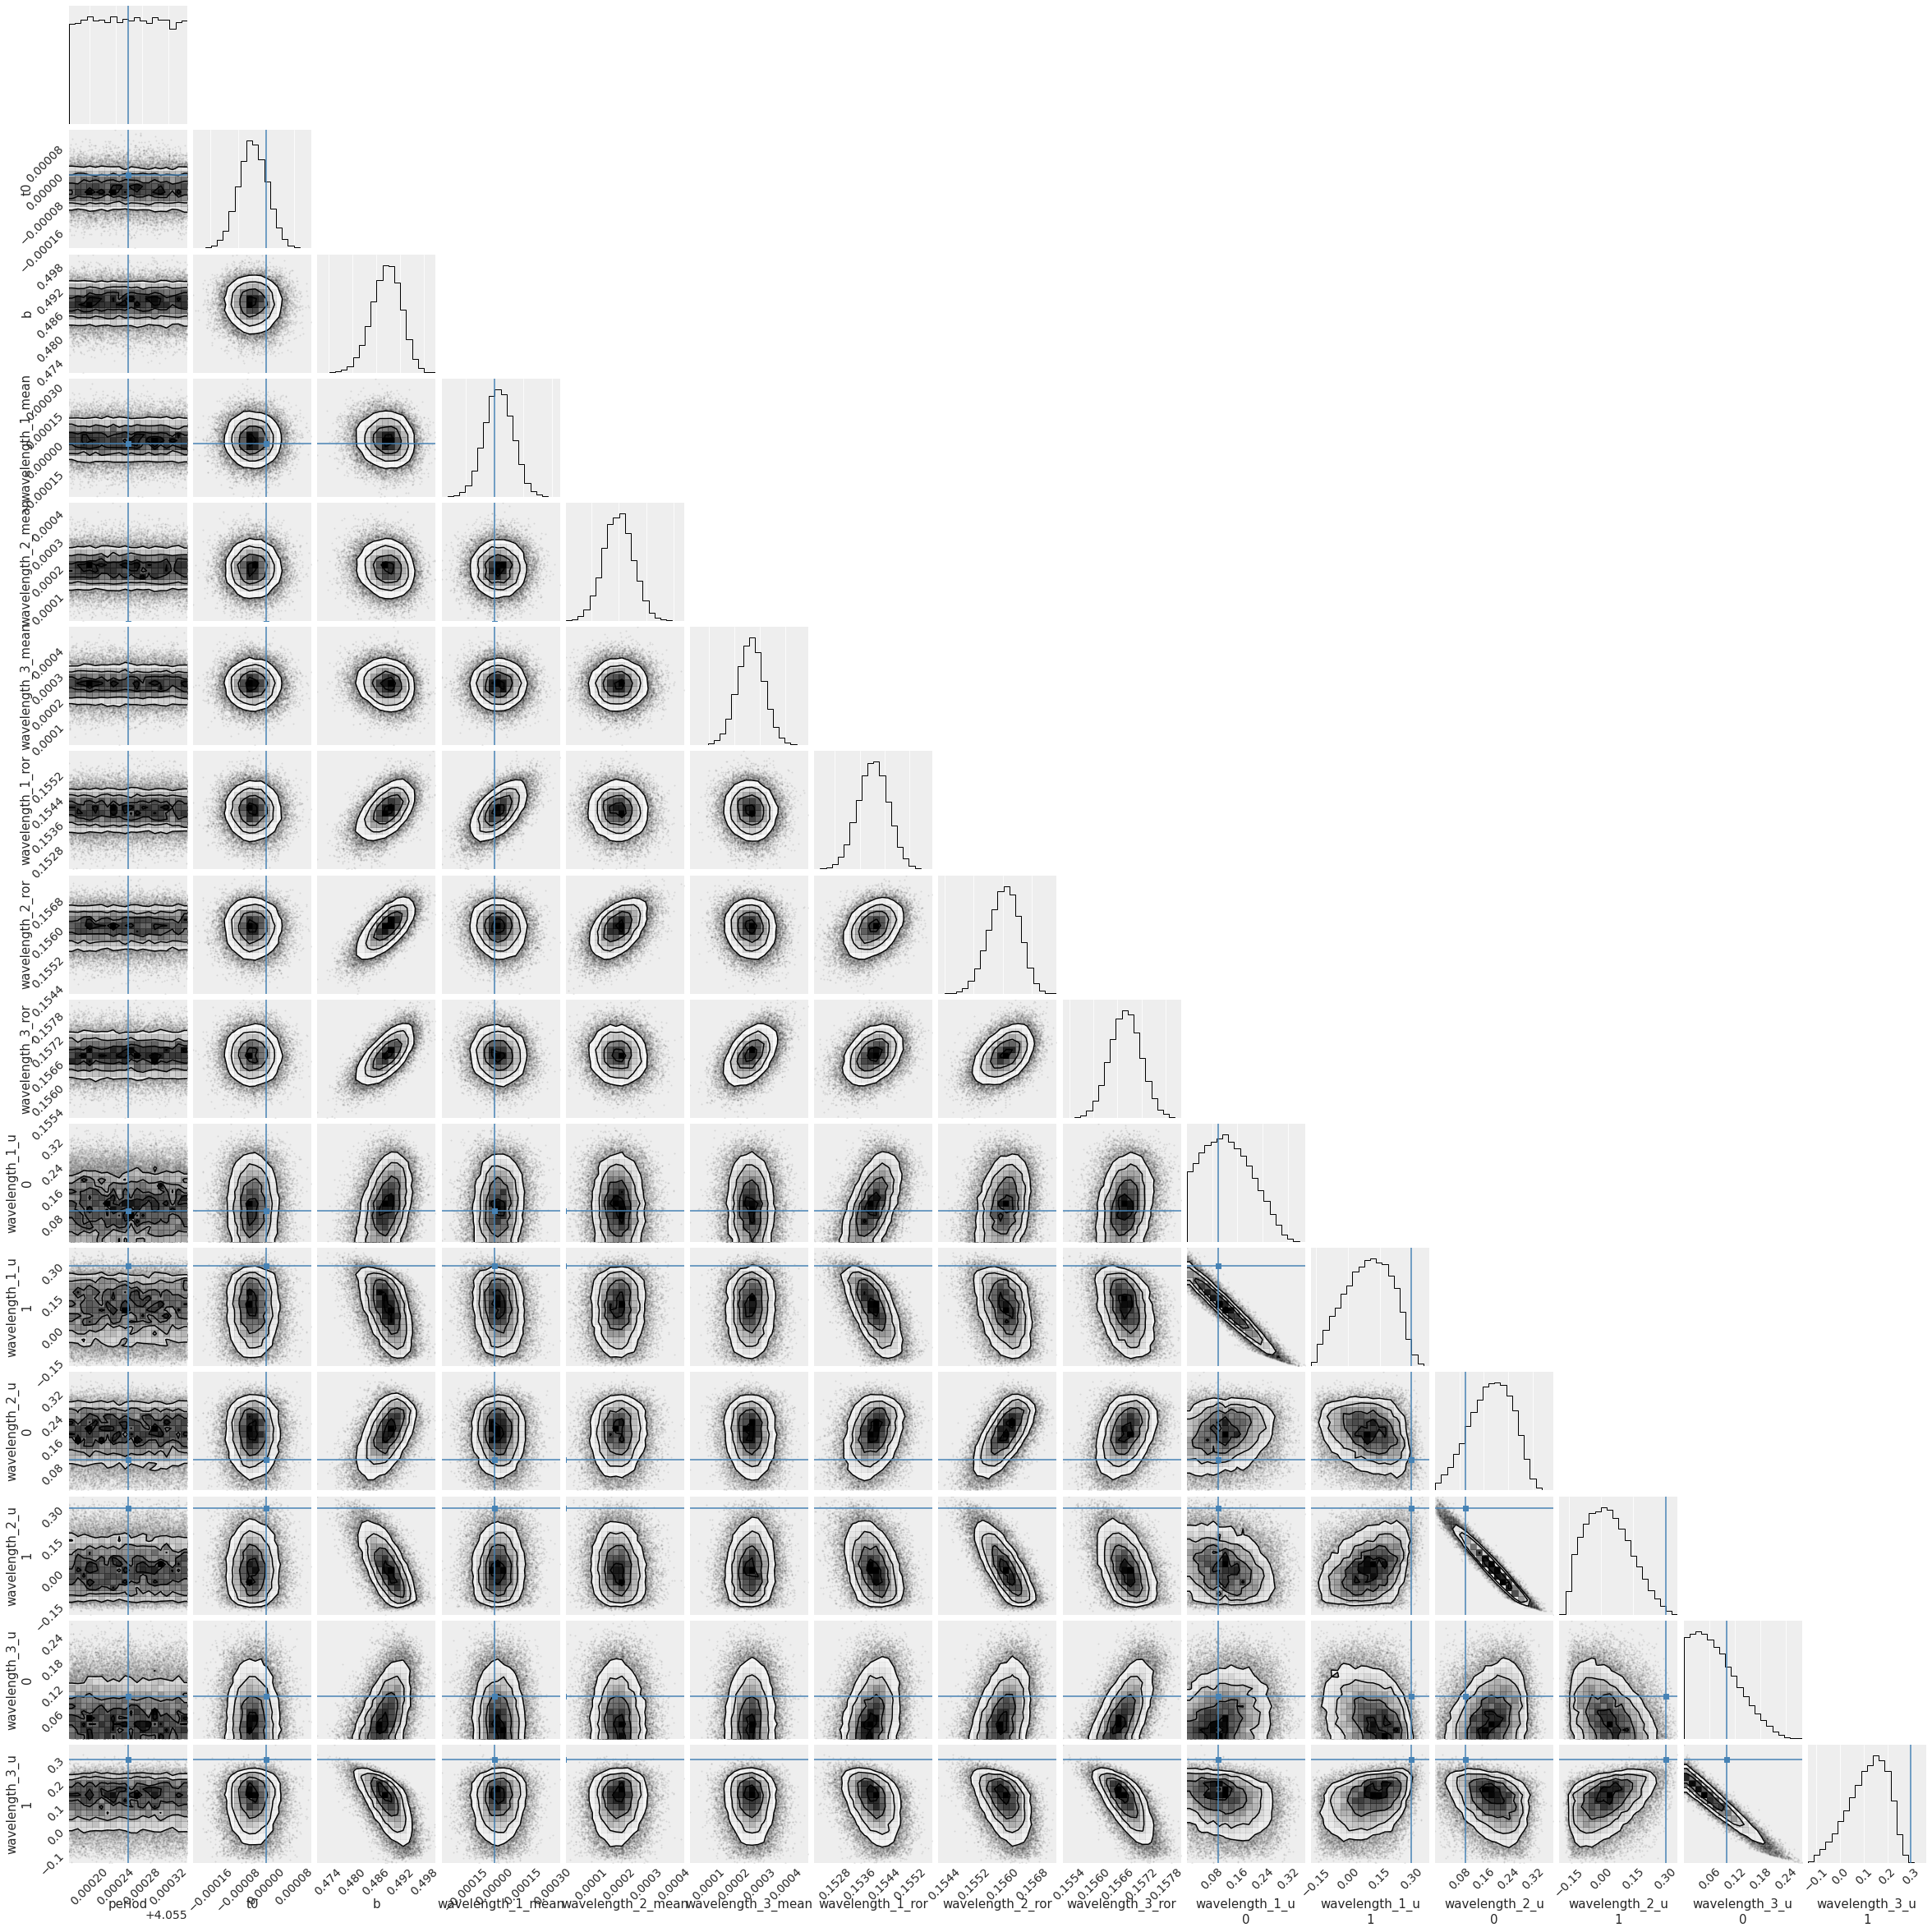

In [22]:
# cm.cornerplot()
# summary = cm.summarise()
# summary
varnames = ['period', 't0', 'b',
            'wavelength_1_mean',  'wavelength_2_mean', 'wavelength_3_mean', 
            'wavelength_1_ror', 'wavelength_2_ror','wavelength_3_ror', 
            'wavelength_1_u', 'wavelength_2_u', 'wavelength_3_u']
all_vars = [cm.model.period,cm.model.t0,cm.model.b,
            cm.model.wavelength_1_mean, cm.model.wavelength_2_mean, cm.model.wavelength_3_mean,
            cm.model.wavelength_1_ror, cm.model.wavelength_2_ror, cm.model.wavelength_3_ror,
            cm.model.wavelength_1_u, cm.model.wavelength_2_u,cm.model.wavelength_3_u
           ]

truth = dict(
    zip(
        varnames,
        pmx.eval_in_model(all_vars, cm.model.test_point, model=cm.model),
        )
    )
_ = corner.corner(
        cm.trace,
        var_names=varnames,
        truths=truth,
    )

In [23]:
with cm.model:
    summary = az.summary(
        cm.trace, var_names=varnames, round_to=7, fmt='wide'
    )
summary

mean        sd        hdi_3%   hdi_97%     mcse_mean  \
period             4.055259  0.000052  4.055177e+00  4.055346  3.000000e-07   
t0                -0.000039  0.000041 -1.157000e-04  0.000039  2.000000e-07   
b                  0.488525  0.003643  4.814477e-01  0.495033  2.530000e-05   
wavelength_1_mean  0.000021  0.000074 -1.149000e-04  0.000161  4.000000e-07   
wavelength_2_mean  0.000198  0.000054  9.820000e-05  0.000300  3.000000e-07   
wavelength_3_mean  0.000264  0.000052  1.641000e-04  0.000361  3.000000e-07   
wavelength_1_ror   0.154023  0.000490  1.531002e-01  0.154938  3.000000e-06   
wavelength_2_ror   0.156030  0.000418  1.552223e-01  0.156778  2.700000e-06   
wavelength_3_ror   0.156793  0.000383  1.560706e-01  0.157504  2.500000e-06   
wavelength_1_u[0]  0.129299  0.075011  2.600000e-06  0.254191  4.638000e-04   
wavelength_1_u[1]  0.093773  0.108479 -1.138905e-01  0.272433  7.053000e-04   
wavelength_2_u[0]  0.182920  0.068924  5.527050e-02  0.305351  4.462000e-04   
wavelength_2_u[1]  0.033083  0.103686 -1.481242e-01  0.215288  7.074000e-04   
wavelength_3_u[0]  0.076992  0.052615  5.000000e-07  0.170850  3.423000e-04   
wavelength_3_u[1]  0.116864  0.082732 -4.180410e-02  0.256352  5.778000e-04   

                        mcse_sd      ess_bulk      ess_tail     r_hat  
period             2.000000e-07  35267.704126  20959.806031  1.000058  
t0                 2.000000e-07  35201.116462  25527.500790  1.000207  
b                  1.790000e-05  21025.478236  20232.328137  1.000038  
wavelength_1_mean  4.000000e-07  35771.744103  25697.962127  1.000122  
wavelength_2_mean  2.000000e-07  32576.444819  24108.535852  1.000152  
wavelength_3_mean  2.000000e-07  35949.727406  25073.688073  0.999993  
wavelength_1_ror   2.100000e-06  27324.044100  23167.927445  1.000083  
wavelength_2_ror   1.900000e-06  23937.267615  22357.962449  1.000269  
wavelength_3_ror   1.800000e-06  23133.664182  23626.341324  0.999983  
wavelength_1_u[0]  3.287000e-04  21689.096083  12689.726396  1.000357  
wavelength_1_u[1]  5.336000e-04  23023.648005  18068.859885  1.000269  
wavelength_2_u[0]  3.349000e-04  21781.139294  13038.089054  1.000115  
wavelength_2_u[1]  5.629000e-04  18696.694654  10828.797118  1.000003  
wavelength_3_u[0]  2.420000e-04  19339.052223  12228.059455  1.000242  
wavelength_3_u[1]  4.086000e-04  20553.315894  20442.753987  1.000210